# ID3 (Iterative Dichotomiser 3)

Write a program to demonstrate the working of the decision tree based ID3 algorithm. Use an appropriate data set for building the decision tree and apply this knowledge toclassify a new sample.

In [32]:
import pandas as pd
import math
import numpy as np

In [33]:
# import dataset
df =pd.read_csv('play_tennis.csv')

In [34]:
df.head()

,Outlook,Temperature,Humidity,Wind,Answer
0,sunny,hot,high,weak,no
1,sunny,hot,high,strong,no
2,overcast,hot,high,weak,yes
3,rain,mild,high,weak,yes
4,rain,cool,normal,weak,yes


### Entropy
 Entropy is a measure of impurity of a collection.
 
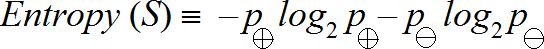

* The entropy is 0 if all members of S belong to the same class
* The entropy is 1 when the collection contains an equal number of positive and negative examples
* If the collection contains unequal numbers of positive and negative examples, the entropy is between 0 and 1

In [35]:
#Function to calculate entropy
def entropy(samples):
    p_pos = len(samples[samples['Answer']=='yes'])/len(samples)
    p_neg = len(samples[samples['Answer']=='no'])/len(samples)
    
    print(f"Calculating Entropy : p_pos = {p_pos} , p_neg = {p_neg} ")
    
    # Conditional check to avoid log(0) throwing an error
    if p_pos==0:
        return -p_neg*math.log(p_neg,2)
    elif p_neg == 0:
        return -p_pos*math.log(p_pos,2)
    else:
        return -p_pos*math.log(p_pos,2) - p_neg*math.log(p_neg,2)

In [36]:
entropy(df)

Calculating Entropy : p_pos = 0.6428571428571429 , p_neg = 0.35714285714285715 


0.9402859586706309

### Information gain
Information gain, is the expected reduction in entropy caused by partitioning the examples according to this attribute.

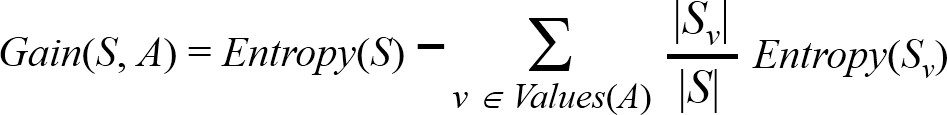

Info Gains tells us how much entropy we can reduce by spitting a sample S on attribute A. 

In [37]:
#Calculate info gain
def info_gain(samples,attribute):
    print('=='*10,attribute,'=='*10)
    # Entropy of entire samples
    entropy_S = entropy(samples)
    print("entropy_S = ",entropy_S)
    
    summation = 0
    # loop over each possible value of the attribute and calculate gain
    for attrib in samples[attribute].unique():
        print('-'*10)
        print("Attribute = ",attrib)
        # ( |S_v| / |S| ) * Entropy(S_v) 
        val = (len(samples[samples[attribute]==attrib])/len(samples)) * entropy(samples[samples[attribute]==attrib])
        summation += val
        
    print("###"*5,f"Infogain on {attribute} is {entropy_S - summation}","###"*5)
    return entropy_S - summation

In [38]:
info_gain(df,'Outlook')

==================== Outlook ====================
Calculating Entropy : p_pos = 0.6428571428571429 , p_neg = 0.35714285714285715 
entropy_S =  0.9402859586706309
----------
Attribute =  sunny
Calculating Entropy : p_pos = 0.4 , p_neg = 0.6 
----------
Attribute =  overcast
Calculating Entropy : p_pos = 1.0 , p_neg = 0.0 
----------
Attribute =  rain
Calculating Entropy : p_pos = 0.6 , p_neg = 0.4 
############### Infogain on Outlook is 0.2467498197744391 ###############


0.2467498197744391

In [39]:
# Simple class to create node of tree
class Node:
    def __init__(self,attrib):
        self.attribute = attrib
        self.children = {}

### Implementing ID3

In [40]:
def id3(root,samples,attributes,target):
    print("Attributes : ",attributes)
    print(samples)
    
    # If the split is homogeneous , either all true/ all false. Assign the target label as attribute
    if len(samples[target]) == len(samples[samples[target]=='yes']):
        print("Reached leaf , returning yes")
        root.attribute = 'yes'
        return root
    
    if len(samples[target])==len(samples[samples[target]=='no']):
        print("Reached leaf , returning no")
        root.attribute = 'no'
        return root
    
    
    # Else 
    
    # Finding index of best attribute to split on | Try this to understand [print("!!!Info gain if split on ",a," is ",info_gain(df,a)) for a in attributes]
    best_attrib_idx = np.argmax([info_gain(samples,a) for a in attributes]) # np.argmax returns idx of max ele 
    print("Index of best split attrib is ",best_attrib_idx)
    
    # The decision attribute for Root ← best_attribute to split on
    root.attribute = attributes[best_attrib_idx]
    # Since this attribute was used to split we wont be needing it anymore
    attributes.remove(root.attribute)
    
    print("removing "+root.attribute+" . . .")
    print("++++"*5,"Split on ",root.attribute,"++++"*5)
    
    # for each possible value of best split attribute
    for a in df[root.attribute].unique():
        print(f"Classifing {root.attribute} on attrib value - ",a)
        
        # If leaf is reached , break
        if root.attribute=="no" or root.attribute=="yes":
            break
        
        # else add child node for each possible value taken by the attribute
        # id3 ( pass a new node to be the child , sample = data only where attribute is of current val,attribute names, target column )
        child = id3(Node(""),samples[samples[root.attribute]==a].drop(root.attribute,axis=1), attributes ,target )
        
        # link the child to parent
        root.children[a]=(child)
    
    return root

In [41]:
# Now to test out the algo

#prep data
attributes = df.columns[:-1].to_list()
print("Attributes " , attributes)
target = df.columns[-1]
print("Targets " , target)

# Get the tree
tree = Node("")
id3(tree ,df,attributes,target)

Attributes  ['Outlook', 'Temperature', 'Humidity', 'Wind']
Targets  Answer
Attributes :  ['Outlook', 'Temperature', 'Humidity', 'Wind']
     Outlook Temperature Humidity    Wind Answer
0      sunny         hot     high    weak     no
1      sunny         hot     high  strong     no
2   overcast         hot     high    weak    yes
3       rain        mild     high    weak    yes
4       rain        cool   normal    weak    yes
5       rain        cool   normal  strong     no
6   overcast        cool   normal  strong    yes
7      sunny        mild     high    weak     no
8      sunny        cool   normal    weak    yes
9       rain        mild   normal    weak    yes
10     sunny        mild   normal  strong    yes
11  overcast        mild     high  strong    yes
12  overcast         hot   normal    weak    yes
13      rain        mild     high  strong     no
==================== Outlook ====================
Calculating Entropy : p_pos = 0.6428571428571429 , p_neg = 0.35714285714285715 

In [42]:
# Function to predict target given sample data
def predict(tree,test_sample):
    # While a leaf is not reached
    while(tree.children!={}):
        nxt = test_sample[tree.attribute]
        # Traverse the tree as per the attribute value in testsample
        tree = tree.children[nxt]
        
    return tree.attribute

In [43]:
total = len(df)
train = df.sample(frac=1).iloc[:int(total*0.7)]
test =  df.sample(frac=1).iloc[int(total*0.7)+1:]

In [44]:
train

,Outlook,Temperature,Humidity,Wind,Answer
12,overcast,hot,normal,weak,yes
3,rain,mild,high,weak,yes
8,sunny,cool,normal,weak,yes
10,sunny,mild,normal,strong,yes
1,sunny,hot,high,strong,no
2,overcast,hot,high,weak,yes
5,rain,cool,normal,strong,no
13,rain,mild,high,strong,no
4,rain,cool,normal,weak,yes


In [45]:
test

,Outlook,Temperature,Humidity,Wind,Answer
8,sunny,cool,normal,weak,yes
3,rain,mild,high,weak,yes
7,sunny,mild,high,weak,no
1,sunny,hot,high,strong,no


In [46]:
tree = Node("")
id3(tree,train,df.columns[:-1].tolist(),df.columns[-1])

Attributes :  ['Outlook', 'Temperature', 'Humidity', 'Wind']
     Outlook Temperature Humidity    Wind Answer
12  overcast         hot   normal    weak    yes
3       rain        mild     high    weak    yes
8      sunny        cool   normal    weak    yes
10     sunny        mild   normal  strong    yes
1      sunny         hot     high  strong     no
2   overcast         hot     high    weak    yes
5       rain        cool   normal  strong     no
13      rain        mild     high  strong     no
4       rain        cool   normal    weak    yes
==================== Outlook ====================
Calculating Entropy : p_pos = 0.6666666666666666 , p_neg = 0.3333333333333333 
entropy_S =  0.9182958340544896
----------
Attribute =  overcast
Calculating Entropy : p_pos = 1.0 , p_neg = 0.0 
----------
Attribute =  rain
Calculating Entropy : p_pos = 0.5 , p_neg = 0.5 
----------
Attribute =  sunny
Calculating Entropy : p_pos = 0.6666666666666666 , p_neg = 0.3333333333333333 
############### Inf

In [47]:
score = 0
for i in range(len(test)):
    pred = predict(tree,test.iloc[i])
    print(f"Attributes {test.iloc[i].values}, Predicted {pred} , target {test.iloc[i].Answer}")
    if  pred == test.iloc[i]["Answer"]:
        score+=1

Attributes ['sunny' 'cool' 'normal' 'weak' 'yes'], Predicted yes , target yes
Attributes ['rain' 'mild' 'high' 'weak' 'yes'], Predicted yes , target yes
Attributes ['sunny' 'mild' 'high' 'weak' 'no'], Predicted yes , target no
Attributes ['sunny' 'hot' 'high' 'strong' 'no'], Predicted no , target no


In [48]:
score

3

In [49]:
len(test)

4

In [50]:
accuracy = score/len(test)
print(accuracy*100)

75.0


# End